# Deep learning for image recognition

The goal of this project is to set up infastructure to aid in the process of training Machine Learning models, the steps in this pipeline are data ingestion, model trainig and model deployment. Every step in the process leverages AWS services to ease development and set up the infrastructure needed for a ML workflow. The data ingestion is done through S3, which can host datasets of large size and diverse formats. For the training phase, there are a variety of tools such as hyperparameter tuning, debugging and profiling. Hyperparameter tuning is a process where the AWS service selects the best hyperparameter combination taken from a list that can be customized by the user. Debugging and profiling are conducted through a hook inserted into the training script, this hook can capture and display data from the training and testing loop in real time.
To complete the ML workflow, the trained model is deployed into a virtual machine, and made available through an API endpoint that enables users to make inferences on custom data (images, in this case).

The same workflow outlined in this notebook can be applied as a template with a different dataset and for other tasks, in a process known as [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning)

In [23]:
#Install needed dependencies
!pip install smdebug


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [3]:
#Import libraries
import sagemaker
import boto3
import os
from torchvision.datasets.stanford_cars import StanfordCars
#For Hyperparameter tuning
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from torchvision import transforms
from sagemaker.pytorch import PyTorch #Estimator

#For debugging and profiling
from sagemaker.debugger import Rule, DebuggerHookConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile


from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

import IPython

#Common AWS objects
session = sagemaker.session.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = session.boto_region_name

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-02-16 01:20:47.542 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:27 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.24b20230214-py3.8.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.24b20230214-py3.8.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?


## Dataset

This project uses the Stanford Cars dataset, which according to its creators:
> Contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

In [4]:
# Creating the dataset as a Pytorch object
local_dir = 'data'
StanfordCars.mirrors = ["https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/StanfordCars/"]
image_dataset = StanfordCars(
    local_dir,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize([244,244])]
    )
)

In [24]:
#Uploading dataset to S3
prefix = "StanfordCars"

inputs = session.upload_data(path="data", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-793615537614/StanfordCars


#### For curious readers:

Datasets included in the pytorch library are listed in this [link](https://pytorch.org/vision/stable/generated/torchvision.datasets.StanfordCars.html#torchvision.datasets.StanfordCars) <br><br>
For the STANFORD CARS dataset, which is used for this project, documentation can be consulted in the [Pytorch website](https://pytorch.org/vision/stable/generated/torchvision.datasets.StanfordCars.html#torchvision.datasets.StanfordCars). Moreover, the original documentation on this dataset can be found [here](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)

## Hyperparameter Tuning
This section uses SageMaker in script mode to select the best hyperpamaters for the selected CNN model. 

The hyperparameters will be automatically selected by SageMaker. The tool will run 8 parallel tuning jobs, which correspond to the 8 possible combinations of hyperprameters given for tuning, at the end of the tuning process, SageMaker will output the best combination of hypeparameters found. 

In [36]:
#Declare hyperparameters that will be tuned
hyperparameter_ranges = {
    "lr": CategoricalParameter([0.01, 0.1]),
    "batch-size": CategoricalParameter([256, 512]),
    'epochs': CategoricalParameter([2,3])
}

In [40]:
estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    py_version='py38',
    framework_version='1.12',
    instance_count=1,
    instance_type='ml.m5.xlarge'
)

#The training script uses cross entropy loss function, as this is a multiclass classification problem
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=8,
    max_parallel_jobs=8,
    objective_type=objective_type
)

In [41]:
#Run the hyperparameter tuning jobs
tuner.fit({'training': inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [43]:
#Get the hyperparameters of the best trained model
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-02-12 04:37:52 Starting - Preparing the instances for training
2023-02-12 04:37:52 Downloading - Downloading input data
2023-02-12 04:37:52 Training - Training image download completed. Training in progress.
2023-02-12 04:37:52 Uploading - Uploading generated training model
2023-02-12 04:37:52 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"3"',
 'lr': '"0.01"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-12-02-31-40-303"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-793615537614/pytorch-training-2023-02-12-02-31-40-303/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
With the hyperparameters obtained in the previous step, this section will use SageMaker in script mode to train and test the model, generating an artifact ready for deployment.

A SageMaker hook will be inserted into the script to allow the users to monitor the trainig process in real time, this hook will also collect data and ensemble a profiler report at the end of the training.

The training and testing code are contained in the `train_model.py` script.

In [14]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
hook_config = DebuggerHookConfig(
    hook_parameters={'train.save_interval': "10", "eval.save_interval": "1000"})
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=5000, framework_profile_params=FrameworkProfile(num_steps=100)
)

In [15]:
#Hyperparameters derived from previous tuning job
best_hyperparameters = {
    'batch-size': '256',
    'epochs': '3',
    'lr': '0.01',
}

estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    py_version='py38',
    framework_version='1.12',
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    hyperparameters=best_hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [18]:
#Run the training and test loop contained in the `train_model.py` script.
estimator.fit({'training': inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-02-16-02-57-48-775


2023-02-16 02:57:49 Starting - Starting the training job...
2023-02-16 02:58:05 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
ProfilerReport: InProgress
......
2023-02-16 02:59:16 Downloading - Downloading input data......
2023-02-16 03:00:21 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-16 03:00:12,824 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-16 03:00:12,826 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-16 03:00:12,828 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-02-16 03:00:12,838 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-16 03:00:12,841 sagemaker_pytorch_container.training INFO     Invoking 

In [19]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job_name = 'pytorch-training-2023-02-16-02-57-48-775'
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-793615537614/', 'ProfilingIntervalInMilliseconds': 5000, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 100, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 100, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 100, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 100, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 100, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-793615537614/pytorch-training-2023-02-16-02-57-48-775/profiler-output


Profiler data from system is available


In [20]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU"],
    select_events=["total"],
)

[2023-02-16 04:09:25.115 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:27 INFO metrics_reader_base.py:134] Getting 70 event files
select events:['total']
select dimensions:['CPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


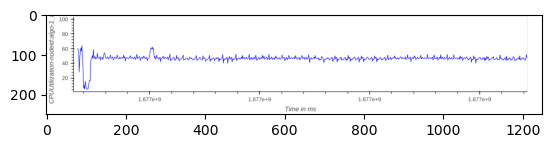

In [3]:
#Displaying the generated CPU usage plot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('cpu_usage_plot.png')
imgplot = plt.imshow(img)
plt.show()

Profiler analysis code taken from [aws github](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_profiling/pt-resnet-profiling-single-gpu-single-node.ipynb)

### Show the profiler report
This cell displays the generated report, which can also be seen as a separate document within this folder (`profiler-report.html`)

In [21]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

2023-02-16 04:08:41     363500 pytorch-training-2023-02-16-02-57-48-775/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-16 04:08:41     209525 pytorch-training-2023-02-16-02-57-48-775/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-16 04:08:37        191 pytorch-training-2023-02-16-02-57-48-775/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-16 04:08:37        199 pytorch-training-2023-02-16-02-57-48-775/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-16 04:08:37       2072 pytorch-training-2023-02-16-02-57-48-775/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-16 04:08:37        127 pytorch-training-2023-02-16-02-57-48-775/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-16 04:08:37        198 pytorch-training-2023-02-16-02-57-48-775/rule-output/ProfilerReport/profiler-output/profiler-re

## Model Deploying
The previous step generated an artifact which consists of the trained model and the script to run predictions on that model. In this step, we will use AWS provisioned infrastructure to upload the model and create an endpoint that can be used to invoke predictions with user defined images.

In [22]:
predictor=estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

INFO:sagemaker:Creating model with name: pytorch-training-2023-02-16-04-26-45-378
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-02-16-04-26-45-378
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-02-16-04-26-45-378


-----!

In [28]:
# The image goes through the transforms defined when creating the dataset at the beginning of this notebook
# The transforms are: 1. transform image to tensor object 2. resize the image to fit model input (244 x 244 RGB image)

from torch import randint
sample_idx = randint(len(image_dataset), size=(1,)).item()
image, label = image_dataset[sample_idx]

image = image.unsqueeze(0)#Adds a dimension in front of the image, as the model expects a tensor of size 4 (batch_size, channels, width, height)

#Ask the endpoint to classify the image
response = predictor.predict(image)
print(response)

[[-14.9828558   -7.18462467  -4.1730566   -5.8168602   -5.31557989
   -7.3323431   -6.88033867  -7.58815765  -4.94617033  -8.56749153
   -9.08531189  -8.98237133  -7.94167328  -6.97027397  -6.70899677
  -15.6803503  -10.7051239  -11.07425785  -6.57576323  -4.28439665
   -9.47986317  -9.79704762  -6.83502531  -5.79636717  -7.80280495
   -5.9516077   -7.98729849  -4.52152538  -7.43041515  -6.93487883
   -8.38533497  -7.17361832  -6.04325294  -5.35902405  -3.99037361
   -7.24512577  -6.12412453  -7.27836609  -8.14006805 -10.97202682
  -12.03221703  -7.38398266  -8.29374123  -6.69008398 -10.68607426
   -7.84497547  -6.72831869  -5.34897947  -4.22060251  -4.07202482
   -5.92886066  -4.99185324  -8.9110899  -11.02114868  -8.00544071
   -7.62163877  -9.44877625  -4.6481452  -11.69565868  -7.2536602
   -4.77673578  -9.08067513  -6.18085051  -9.70236397  -7.84622192
   -7.28109455  -7.45898056  -8.32450485 -10.25645542 -12.39648533
   -9.82196808  -5.56873131  -8.40819263 -10.80032063  -9.43325

In [31]:
#From the resulting array, select the prediction with the highest probability
labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Most likely answer: (116, 1.7885642051696777)


In [33]:
print(f'The correct label for this image was: {label}. The predicted label was: {labeled_predictions[0][0]}')

The correct label for this image was: 116. The predicted label was: 116


In [30]:
#Deleting the endpoint to stop resource consumption
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2023-02-16-04-26-45-378
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2023-02-16-04-26-45-378
